In [1]:

import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model, save_model
from matplotlib.patches import Rectangle

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, confusion_matrix, classification_report


## GPU Setup:

## Required Constants Declared:

In [4]:
BATCH_SIZE = 16
EPOCHS =1
n_splits = 5
fold_selected = 2   
IMAGE_WIDTH = 224 #256
IMAGE_HEIGHT = 224 #256

## Supplementary Functions: Preprocessing

In [5]:
def preprocessing(df, subset="train"):
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    if (subset=="train") or (DEBUG):
        DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] 

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    del x, path_partial_list, tmp_df
    
    return df

## Supplementary Functions : RLE Encoding and Decoding

In [7]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.array(mask_rle.split(), dtype=int)   
    starts = s[0::2] - 1 # Every even value is the start, every odd value is the "run" length
    lengths = s[1::2]
    ends = starts + lengths
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color    
    return img.reshape(shape)

In [8]:
#run length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Definition of Metrics:

In [9]:

# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    
    print(y_true_f)
    print(y_pred_f)
    
  



    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

#Keras
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky

## Data Generator Wrapper Function:

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.width=width
        self.height=height
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    #def on_epoch_end(self):
     #   if self.shuffle == True:
      #      np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,self.width,self.height,3))
        y = np.empty((self.batch_size,self.width,self.height,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img  
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (self.width, self.height))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X,y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        #img = img.astype(np.float32) / 255.
        img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
        img = np.expand_dims(img, axis=-1)
        return img

## Data Setup:

In [12]:
print("\n... DATA ACCESS SETUP STARTED ...\n")

DATA_DIR = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
save_locally = None
load_locally = None



... DATA ACCESS SETUP STARTED ...



In [13]:
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


### Test Data Definition:

In [14]:
TEST_CSV = os.path.join(DATA_DIR, 'sample_submission.csv')
test_df = pd.read_csv(TEST_CSV)
separate_test = True
if len(test_df)==0:
    DEBUG=True
    test_df = train_df[-test_split:]
    test_df_disp = test_df.copy()
    y_test = test_df_disp["segmentation"]
    submission=test_df.copy()
    submission['prediction'] = ''
    if separate_test == True:
        train_df = train_df[:-test_split]
else:
    DEBUG=False

print(submission.head())
print(test_df.head())

                            id        class segmentation prediction
115188  case30_day0_slice_0045  large_bowel          NaN           
115189  case30_day0_slice_0045  small_bowel          NaN           
115190  case30_day0_slice_0045      stomach          NaN           
115191  case30_day0_slice_0046  large_bowel          NaN           
115192  case30_day0_slice_0046  small_bowel          NaN           
                            id        class segmentation
115188  case30_day0_slice_0045  large_bowel          NaN
115189  case30_day0_slice_0045  small_bowel          NaN
115190  case30_day0_slice_0045      stomach          NaN
115191  case30_day0_slice_0046  large_bowel          NaN
115192  case30_day0_slice_0046  small_bowel          NaN


### Preprocessing Data:

In [15]:
train_df = preprocessing(train_df, subset="train")
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [16]:
test_df_pred = preprocessing(test_df, subset="test")

test_df_disp = preprocessing(test_df_disp, subset="train")



### EDA Display:


... SINGLE ID EXPLORATION ...




,81
id,case123_day20_slice_0082
large_bowel,17481 4 17746 7 18010 10 18275 12 18539 14 188...
small_bowel,22236 2 22500 6 22765 8 23030 10 23296 10 2356...
stomach,11052 8 11314 15 11578 19 11843 23 12108 26 12...
path,../input/uw-madison-gi-tract-image-segmentatio...
case,123
day,20
slice,0082
width,266
height,266




...IMAGE ...



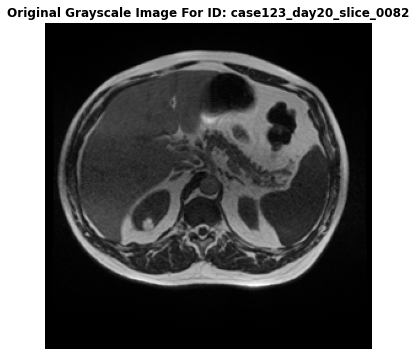



... 3 SEGMENTATION MASKS ...



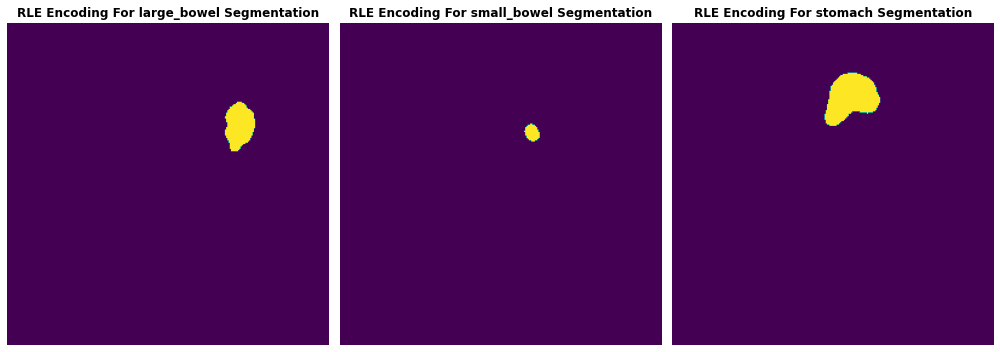



...IMAGE WITH AN RGB SEGMENTATION MASK OVERLAY ...



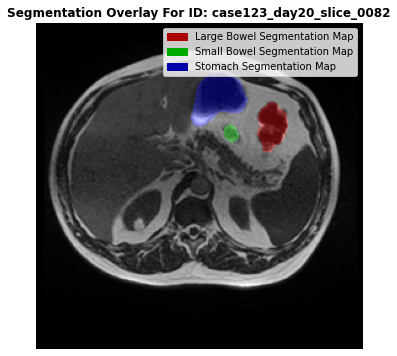

In [20]:
print("\n... SINGLE ID EXPLORATION ...\n\n")
DEMO_ID = "case123_day20_slice_0082"
examine_id(DEMO_ID, seg_masks=True)

### Data Grouping:

In [21]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

print(train_df.groupby('fold').size())
print(X_train.head())

fold
1    8208
2    7036
3    7392
4    8704
5    6768
dtype: int64
                          id large_bowel small_bowel stomach  \
432  case77_day20_slice_0001                                   
433  case77_day20_slice_0002                                   
434  case77_day20_slice_0003                                   
435  case77_day20_slice_0004                                   
436  case77_day20_slice_0005                                   

                                                  path  case  day slice  \
432  ../input/uw-madison-gi-tract-image-segmentatio...    77   20  0001   
433  ../input/uw-madison-gi-tract-image-segmentatio...    77   20  0002   
434  ../input/uw-madison-gi-tract-image-segmentatio...    77   20  0003   
435  ../input/uw-madison-gi-tract-image-segmentatio...    77   20  0004   
436  ../input/uw-madison-gi-tract-image-segmentatio...    77   20  0005   

     width  height  count  fold  
432    266     266      0     4  
433    266     266      0   

In [22]:
# Fold sizes
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4803
      1         494
      2        2218
      3         693
2     0        4086
      1         352
      2        1972
      3         626
3     0        4164
      1         552
      2        2105
      3         571
4     0        4748
      1         606
      2        2614
      3         736
5     0        3860
      1         451
      2        1928
      3         529
Name: id, dtype: int64

In [23]:
! pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [24]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

### Model Definition: UNet with Pretrained MobileNetV2

In [25]:
def model_def():
    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input_image")
    ## Change channel size? OR change tensor size above?
    ## Add preprocessing layer here
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    #encoder.trainable = False ## Are we supposed to use a trained base? Yes
    encoder.trainable = True ## Are we supposed to use a trained base? Yes
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(3, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x) #Tanh gives between -1 to 1, same as our preprocessing // Sigmoid, as output masks will be between 0 to 1
    
    model = Model(inputs, x)
    return model

In [26]:
#Data generators 
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)
train_generator

### Model Creation, Compilation, Training:

2022-08-18 04:35:47.603182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 04:35:47.806395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 04:35:47.811161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 04:35:47.818071: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________

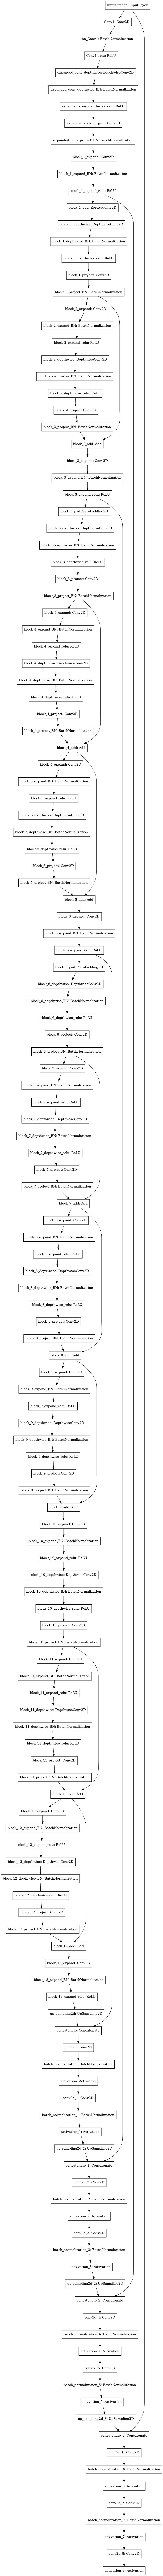

In [27]:
model = model_def()
opt = tf.keras.optimizers.Nadam(1e-4)
metrics=[dice_coef,iou_coef]
loss = FocalTverskyLoss
model.summary()
plot_model(model)

In [28]:
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [29]:
checkpoint = ModelCheckpoint(
    'MobileNetV2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)


In [30]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    #callbacks=[checkpoint, early_stopping, lr_scheduler],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
    #epochs = 1
)
#def scheduler(epoch, lr):
 #       if epoch < 20:
  #          return lr
   #     else:
    #        return lr * tf.math.exp(-0.1)
#lr_scheduler = LearningRateScheduler(scheduler)

2022-08-18 04:35:57.931839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Tensor("Reshape:0", shape=(None,), dtype=float32)
Tensor("Reshape_1:0", shape=(None,), dtype=float32)
Tensor("Reshape:0", shape=(None,), dtype=float32)
Tensor("Reshape_1:0", shape=(None,), dtype=float32)


2022-08-18 04:36:14.399043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1942/1942 [==============================] - ETA: 0s - loss: 0.9647 - dice_coef: 0.0353 - iou_coef: 0.0185Tensor("Reshape:0", shape=(None,), dtype=float32)
Tensor("Reshape_1:0", shape=(None,), dtype=float32)
1942/1942 [==============================] - 374s 180ms/step - loss: 0.9647 - dice_coef: 0.0353 - iou_coef: 0.0185 - val_loss: 0.9478 - val_dice_coef: 0.0522 - val_iou_coef: 0.0278

Epoch 00001: val_loss improved from inf to 0.94783, saving model to MobileNetV2_model.keras


### Training Results:

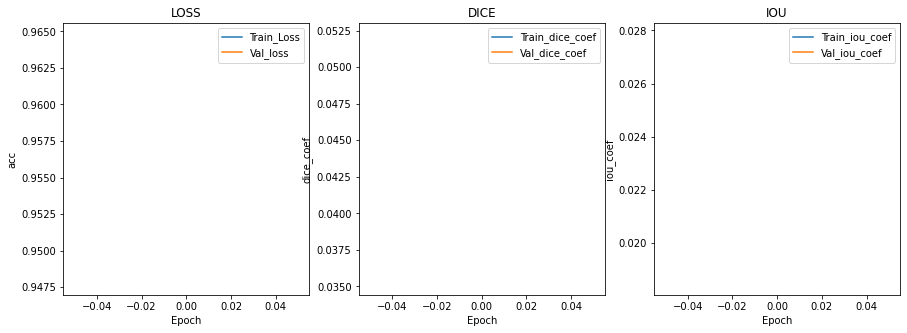

In [31]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('acc');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

In [ ]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'FocalTverskyLoss' : FocalTverskyLoss
}
model = load_model('./MobileNetV2_model.keras', custom_objects=custom_objects)

### Mask Prediction Visualisation on Test Dataset

In [ ]:
num_img = 3
start = 63
pred_batches = DataGenerator(test_df_disp.iloc[start:start+num_img,:], batch_size = 1, subset="train", shuffle=False)
print("Prediction Scores: Loss, Dice_coef, IOU_coef:",model.evaluate(pred_batches, verbose = 1))
preds = model.predict_generator(pred_batches,verbose=1)

Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(num_img):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')

### Model Prediction:

In [ ]:
#test = test_df_pred.iloc[start:start+num_img,:]
test = test_df_pred.copy()
print(test.shape)
print("Prediction Scores: Loss, Dice_coef, IOU_coef:",model.evaluate(pred_batches, verbose = 1))
pred_batches = DataGenerator(test, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)  
    
    # Rle encode
    for j in range(BATCH_SIZE):
        
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test.loc[i*BATCH_SIZE+j,"width"], test.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            rle_out = rle_encode(pred_img)
            #print(rle_out)
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_out